In [370]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay


from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras import backend as K


# Data Exploration

In [266]:
DATA_PATH = '../InfraredSolarModules'
METADATA_PATH = os.path.join(DATA_PATH, 'module_metadata.json')
SEED = 42

In [9]:
df = pd.read_json(METADATA_PATH, orient='index').sort_index()
df['image_filepath'] = df['image_filepath'].apply(lambda x: os.path.join(DATA_PATH, x))
df

,image_filepath,anomaly_class
0,../InfraredSolarModules\images/0.jpg,Offline-Module
1,../InfraredSolarModules\images/1.jpg,Offline-Module
2,../InfraredSolarModules\images/2.jpg,Offline-Module
3,../InfraredSolarModules\images/3.jpg,Offline-Module
4,../InfraredSolarModules\images/4.jpg,Offline-Module
...,...,...
19995,../InfraredSolarModules\images/19995.jpg,No-Anomaly
19996,../InfraredSolarModules\images/19996.jpg,No-Anomaly
19997,../InfraredSolarModules\images/19997.jpg,No-Anomaly
19998,../InfraredSolarModules\images/19998.jpg,No-Anomaly


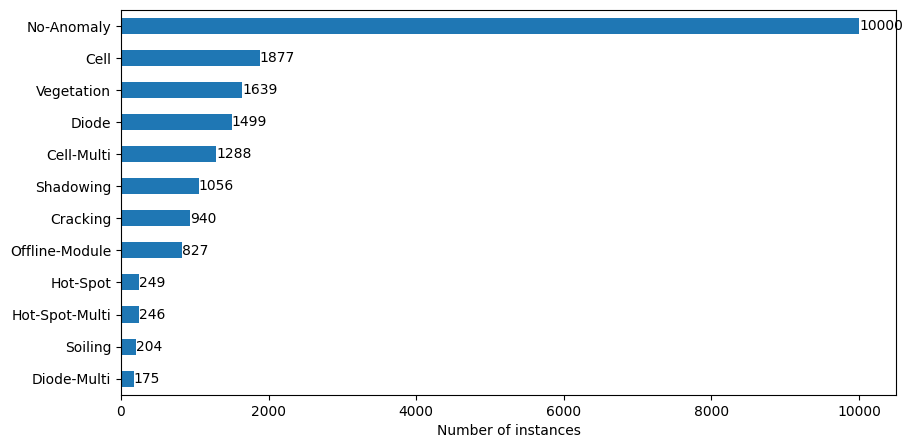

In [10]:
ax = df['anomaly_class'].value_counts().sort_values(ascending=True).plot.barh(figsize=(10,5))
ax.bar_label(ax.containers[0])
ax.set_xlabel('Number of instances')
plt.show()

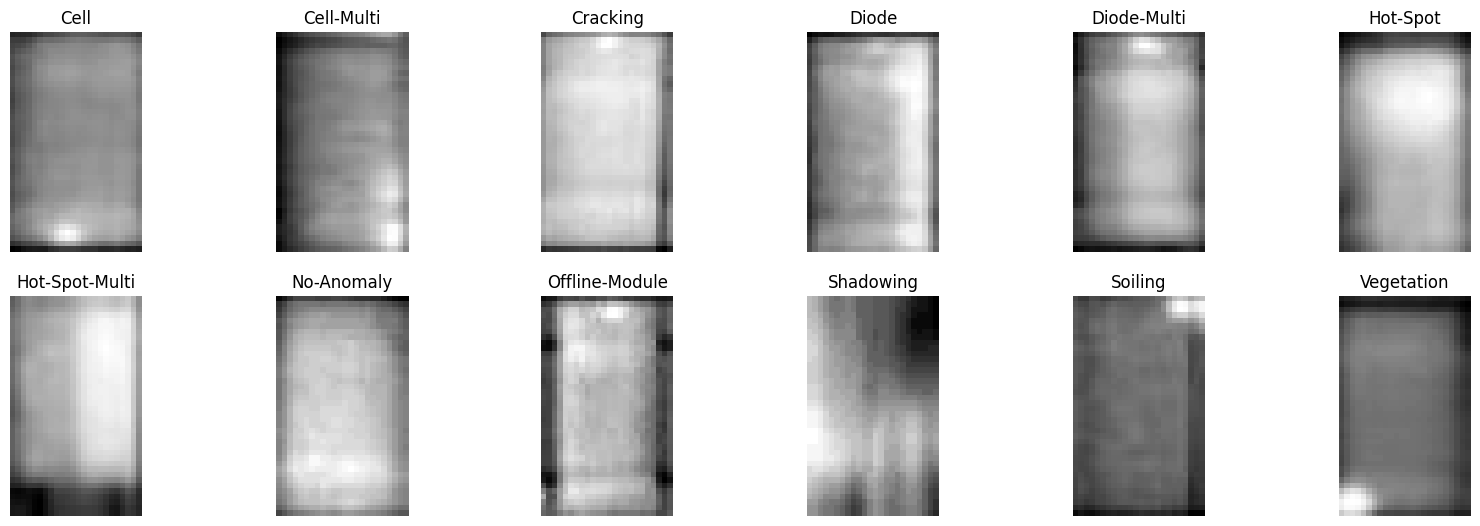

In [33]:
sample = df.groupby('anomaly_class').sample()

plt.figure(figsize=(20,20))
for i, (image_path, class_name) in enumerate(sample.values, start=1):
    image = mpimg.imread(image_path)
    plt.subplot(6, 6, i)
    plt.imshow(image, cmap='gray')
    plt.title(class_name)
    plt.axis('off')
plt.show()

# Pre-processing

In [244]:
# create binary dataset: No anomaly and anomaly
df_noanomaly = df[df['anomaly_class'] == 'No-Anomaly'].reset_index(drop=True)
df_anomaly = df[df['anomaly_class'] != 'No-Anomaly'].reset_index(drop=True)

In [267]:
# Randomly choose indices from no_anomaly class for test dataset
PICK = 0.005 # percentage
np.random.seed(SEED)
selected_indices = np.random.choice(len(df_noanomaly), size=int(len(df_noanomaly) * PICK), replace=False)

# Randomly choose samples from each class in anomaly dataframe for test dataset
PICK = 5 # sample
tmp = df_anomaly.groupby('anomaly_class').sample(PICK)

In [270]:
# Create X_test
X_test_df = df_noanomaly.loc[selected_indices].reset_index(drop=True)
X_test_df = pd.concat([X_test_df, tmp], ignore_index=True)

# Shuffle X_test
X_test_df = X_test_df.sample(frac=1,random_state=SEED).reset_index(drop=True)

# Create X_train
X_train_df = df_noanomaly.drop(index=selected_indices).reset_index(drop=True)

In [271]:
X_test_df

,image_filepath,anomaly_class
0,../InfraredSolarModules\images/10321.jpg,No-Anomaly
1,../InfraredSolarModules\images/1357.jpg,Diode
2,../InfraredSolarModules\images/7206.jpg,Cracking
3,../InfraredSolarModules\images/5882.jpg,Cell
4,../InfraredSolarModules\images/10039.jpg,No-Anomaly
...,...,...
100,../InfraredSolarModules\images/845.jpg,Diode-Multi
101,../InfraredSolarModules\images/13999.jpg,No-Anomaly
102,../InfraredSolarModules\images/3149.jpg,Shadowing
103,../InfraredSolarModules\images/5114.jpg,Cell


In [272]:
# Read image to numpy array
def build_dataset(df: pd.DataFrame):
    X = []
    y = []
    for i in range(len(df)):
        X.append(mpimg.imread(df.loc[i]['image_filepath']))
        if df.loc[i]['anomaly_class'] == 'No-Anomaly':
            y.append(0)
        else:
            y.append(1)
    X = np.array(X)
    y = np.array(y)
    return X,y

In [296]:
X_train, _ = build_dataset(X_train_df)
X_test, y_test = build_dataset(X_test_df)

In [297]:
X_train = np.expand_dims(X_train, axis=-1)
X_train = X_train / 255

X_test = np.expand_dims(X_test, axis=-1)
X_test = X_test / 255

In [283]:
# from sklearn.preprocessing import MinMaxScaler
# import numpy as np

# # Assuming X_train is your original training data with shape (9950, 40, 24)
# X_train = np.random.rand(9950, 40, 24)

# # Reshape the data to (9950, 960) before scaling
# X_train_reshaped = X_train.reshape((9950, -1))

# # Create a MinMaxScaler with specified range
# min_max_scaler = MinMaxScaler(feature_range=(0, 255))

# # Fit and transform the reshaped training data
# X_train_scaled = min_max_scaler.fit_transform(X_train_reshaped)

# # Inverse transform to get back the original values
# X_train_original_reshaped = min_max_scaler.inverse_transform(X_train_scaled)

# # Reshape the data back to the original shape
# X_train_original = X_train_original_reshaped.reshape(X_train.shape)

# # Display the shapes for verification
# print("Original X_train shape:", X_train.shape)
# print("Scaled X_train shape:", X_train_scaled.shape)
# print("Converted X_train shape:", X_train_original.shape)


# Autoencoder Class

In [387]:
class ConvAutoencoder:
	@staticmethod
	def build(height, width, depth, filters=(32, 64), latentDim=16):
		# initialize the input shape to be "channels last" along with
		# the channels dimension itself
		# channels dimension itself
		inputShape = (height, width, depth)
		chanDim = -1
        
        # define the input to the encoder
		inputs = Input(shape=inputShape)
		x = inputs
		
        # loop over the number of filters
		for f in filters:
			# apply a CONV => RELU => BN operation
			x = Conv2D(f, kernel_size=(3, 3), strides=2, padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)
		
        # flatten the network and then construct our latent vector
		volumeSize = K.int_shape(x)
		x = Flatten()(x)
		latent = Dense(latentDim)(x)
		
        # build the encoder model
		encoder = Model(inputs, latent, name="encoder")
		
        # start building the decoder model which will accept the
		# output of the encoder as its inputs
		latentInputs = Input(shape=(latentDim,))
		x = Dense(np.prod(volumeSize[1:]))(latentInputs)
		x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)
		
        # loop over our number of filters again, but this time in
		# reverse order
		for f in filters[::-1]:
			# apply a CONV_TRANSPOSE => RELU => BN operation
			x = Conv2DTranspose(f, kernel_size=(3, 3), strides=2,
				padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)
			
        # apply a single CONV_TRANSPOSE layer used to recover the
		# original depth of the image
		x = Conv2DTranspose(depth, kernel_size=(3, 3), padding="same")(x)
		outputs = Activation("sigmoid")(x)
		# build the decoder model
		decoder = Model(latentInputs, outputs, name="decoder")
		# our autoencoder is the encoder + decoder
		autoencoder = Model(inputs, decoder(encoder(inputs)),
			name="autoencoder")
		# return a 3-tuple of the encoder, decoder, and autoencoder
		return (encoder, decoder, autoencoder)

In [407]:
# construct convolutional autoencoder
EPOCHS = 10
INIT_LR = 1e-3
BS = 32
(encoder, decoder, autoencoder) = ConvAutoencoder.build(40, 24, 1)
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
autoencoder.compile(loss="mse", optimizer=opt)

In [408]:
# train the convolutional autoencoder
H = autoencoder.fit(
	X_train, X_train,
	validation_data=(X_test, X_test),
	epochs=EPOCHS,
	batch_size=BS)

Epoch 1/10
311/311 [==============================] - 21s 64ms/step - loss: 0.0038 - val_loss: 0.0244
Epoch 2/10
311/311 [==============================] - 18s 57ms/step - loss: 0.0013 - val_loss: 0.0043
Epoch 3/10
311/311 [==============================] - 18s 57ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 4/10
311/311 [==============================] - 19s 61ms/step - loss: 0.0010 - val_loss: 9.7862e-04
Epoch 5/10
311/311 [==============================] - 19s 62ms/step - loss: 9.2495e-04 - val_loss: 8.9608e-04
Epoch 6/10
311/311 [==============================] - 19s 61ms/step - loss: 8.8248e-04 - val_loss: 9.1073e-04
Epoch 7/10
311/311 [==============================] - 20s 63ms/step - loss: 9.1377e-04 - val_loss: 0.0010
Epoch 8/10
311/311 [==============================] - 19s 62ms/step - loss: 9.5989e-04 - val_loss: 9.2092e-04
Epoch 9/10
311/311 [==============================] - 19s 60ms/step - loss: 8.3458e-04 - val_loss: 8.4586e-04
Epoch 10/10
311/311 [=====================

In [409]:
def visualize_predictions(decoded, X_test, y_test, samples=2):
	idx = 1
	# loop over our number of output samples
	for i in range(0, samples):
		
		# grab the original image and reconstructed image
		original = X_test[i]
		recon = decoded[i]
		if y_test[i] == 0:
			title = 'No-Anomaly'
		else:
			title = 'Anomaly'
		
		plt.subplot(samples,2, idx)
		plt.imshow(original, cmap='gray')
		plt.title('Ori: ' + title)
		plt.axis('off')
		idx += 1

		plt.subplot(samples,2, idx)
		plt.imshow(recon, cmap='gray')
		plt.title('recon')
		plt.axis('off')
		idx += 1

		# plt.show()

4/4 [==============================] - 0s 20ms/step


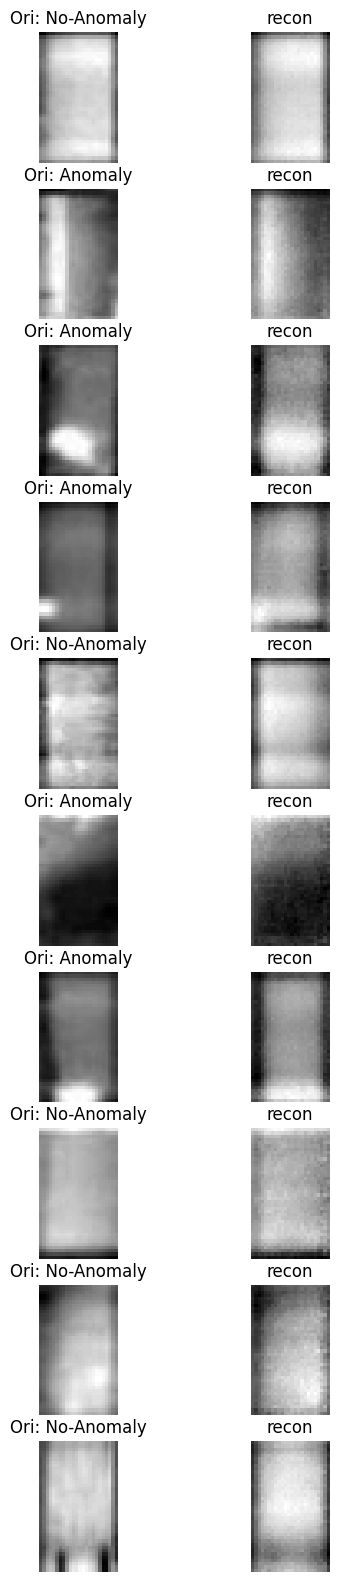

In [410]:
decoded = autoencoder.predict(X_test)
plt.figure(figsize=(5,20))
vis = visualize_predictions(decoded, X_test, y_test,10)

In [411]:
def plot_loss(hist):
    fig = plt.figure()
    plt.plot(hist.history['loss'], color='teal', label='loss')
    plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
    fig.suptitle('Model Loss', fontsize=20)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')   
    plt.legend()

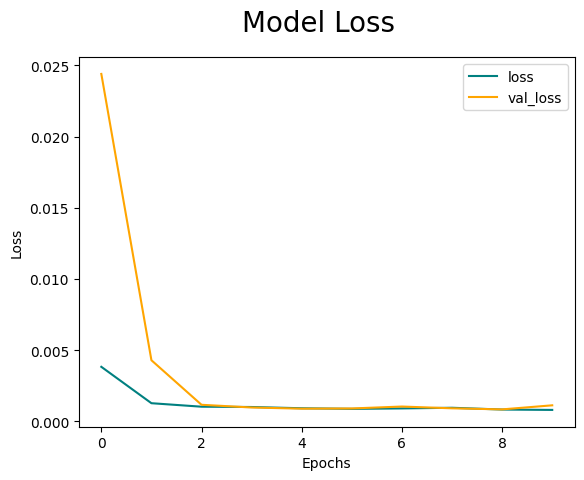

In [413]:
plot_loss(H)

In [414]:
QUANTILE = 0.5
errors = []
# loop over all original images and their corresponding
# reconstructions
for (image, recon) in zip(X_test, decoded):
	# compute the mean squared error between the ground-truth image
	# and the reconstructed image, then add it to our list of errors
	mse = np.mean((image - recon) ** 2)
	errors.append(mse)
	
# compute the q-th quantile of the errors which serves as our
# threshold to identify anomalies -- any data point that our model
# reconstructed with > threshold error will be marked as an outlier
thresh = np.quantile(errors, QUANTILE)
outlier_idxs = np.where(np.array(errors) >= thresh)[0]
print("[INFO] mse threshold: {}".format(thresh))
print("[INFO] {} outliers found".format(len(outlier_idxs)))

[INFO] mse threshold: 0.0009549494303932142
[INFO] 53 outliers found


In [415]:
y_pred = np.zeros(len(X_test))
y_pred[outlier_idxs] = 1

In [416]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.70      0.69        50
           1       0.72      0.69      0.70        55

    accuracy                           0.70       105
   macro avg       0.70      0.70      0.69       105
weighted avg       0.70      0.70      0.70       105



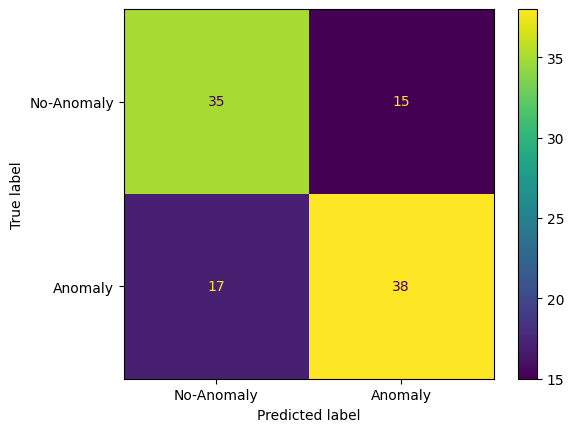

In [418]:
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred,display_labels=['No-Anomaly', 'Anomaly'])